In [7]:
import os
import shutil
import glob
import SimpleITK as sitk
import six
import radiomics
import getopt
import sys
from pydicom import dcmread
import dicom2nifti
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from radiomics import featureextractor, getTestCase
import pydicom
import pydicom_seg
import SimpleITK as sitk
import ast
import json
import pandas
import seaborn as sns
# importing the zipfile module
from zipfile import ZipFile
from sklearn.model_selection import KFold ,StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import statistics
# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from scipy import interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import matplotlib
from scipy.stats import f

from zipfile import ZipFile
BASE_PATH = "/data4/hrehman/Clinical_Data/"

# BASE_PATH_zipped = "/data/radiogenomics/data/NSCLC_Radiogenomics/raw/"
# INPUT_FOLDER = 'data4/Clinical Data/3-13-2023/'
INPUT_FOLDER = BASE_PATH + '3-13-2023/'
# INPUT_FOLDER_zipped = BASE_PATH_zipped
# patients_zipped = os.listdir(INPUT_FOLDER_zipped)
# patients_zipped.sort()
segmentaion_dict = {}

Comparison of brain test images from github with the data we have and see if everything is ok

# Feature Extraction:

At this point we dont have to work with the conversion of the data anymore , we already have the relavent CT and the segmentation with us. Reading patinets data and try to extract the features

In [8]:
patients = os.listdir(INPUT_FOLDER)
patients.sort()
config_patinets = os.listdir(BASE_PATH + "Nifti/config")
len(config_patinets)

137

In [7]:
#Once all the files are unzipped into a new location , we will read all the patinets
patients = os.listdir(INPUT_FOLDER)
patients.sort()
params = './params.yml'
extractor = featureextractor.RadiomicsFeatureExtractor(params)
features = {}

for patient in patients:
    if str(patient+'.txt') in config_patinets:
        path = BASE_PATH + "Nifti/" + patient
        print(patient)
        image = sitk.ReadImage(path + "/CT/"+patient+"_clean.nii")
        mask = sitk.ReadImage(path + "/SEG/"+patient+"_clean.nii")
        # image = sitk.Cast(image,sitk.sitkInt16)
        # mask = sitk.Cast(mask,sitk.sitkInt16)
        # Since the origin and the physical space issue is encountred, we will set them same for both of the images
        # get physical info for image
        spacing = image.GetSpacing()
        direction = image.GetDirection()
        origin = image.GetOrigin()
        # set physical info
        mask.SetSpacing(spacing)
        mask.SetOrigin(origin)
        mask.SetDirection(direction)
        features[patient] = extractor.execute( image, mask)

R01-001


RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "/data4/hrehman/Clinical_Data/Nifti/R01-001/CT/R01-001output.nii" does not exist.

In [4]:
import json
import numpy as np

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

dumped = json.dumps(features, cls=NumpyEncoder)

with open(BASE_PATH + "Nifti/features.json", 'w') as f:
    json.dump(dumped, f)

In [5]:
with open(BASE_PATH + "Nifti/features.json", 'r') as f:
    data_read = json.load(f)

In [6]:
# A list of the valid features from any case id, sorted
feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), features.get('R01-003'))))

In [7]:
len(patients)

137

In [8]:
# Make a numpy array of all the values
import numpy as np
count = 0
samples = np.zeros((len(config_patinets),len(feature_names)))
for patient in patients:
    if str(patient+'.txt') in config_patinets:
        a = np.array([])
        for feature_name in feature_names:
            a = np.append(a, features[patient][feature_name])
        samples[count,:] = a
        count +=1
# May have NaNs
samples = np.nan_to_num(samples)

Now that we have all the features from all the patients from available dataset of 5 ids, we will use the above feature names and perform scaling

# Dimensionality Reduction

## Multidimensional scaling:

Multidimensional scaling or MDS is as way to visualize very high dimensional data in a lower dimensional space. In our case, the feature space is len(feature_names) (or 93) dimensional space. To help us understand the data, we project into 2d space. MDS preserves the relative distance between sample points during the projection, so two samples close together in 2d space would also be close together in the original 93-dimensional space (and vice versa).

We us non-metric algorithm, because our data are highly non uniform in the scale of each feature.

In [9]:
#With no metrics
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

similarities = euclidean_distances(samples)


seed = np.random.RandomState(seed=3)

mds = manifold.MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed,
                   n_init=len(config_patinets),
                   dissimilarity="precomputed", n_jobs=1, metric=False)
pos_MDS = mds.fit_transform(similarities)

/home/hrehman/radiomics_venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


## PCA:

In [10]:
#With metrics
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

similarities = euclidean_distances(samples)


seed = np.random.RandomState(seed=3)

mds = manifold.MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed,
                   n_init=len(config_patinets),
                   dissimilarity="precomputed", n_jobs=1, metric=True)
pos_PCA = mds.fit_transform(similarities)

/home/hrehman/radiomics_venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


# Plots

Here we use the results. NB: there are two points in the "green-ish" colored circle in the center of the plot.

Looking over our features, it's likely that meningioma and astrocytoma could be distinguisted by a classifier (based on our rather limited data set), but, in at least one case, glioma and astrocytoma features are relatively close together.

In [3]:
import pandas 
clinicalData = pandas.read_csv("/data4/hrehman/Clinical_Data/NSCLCR01Radiogenomic_DATA_LABELS_2018-05-22_1500-shifted.csv")
clinicalData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 40 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Case ID                                            211 non-null    object 
 1   Patient affiliation                                211 non-null    object 
 2   Age at Histological Diagnosis                      211 non-null    int64  
 3   Weight (lbs)                                       211 non-null    object 
 4   Gender                                             211 non-null    object 
 5   Ethnicity                                          211 non-null    object 
 6   Smoking status                                     211 non-null    object 
 7   Pack Years                                         163 non-null    object 
 8   Quit Smoking Year                                  108 non-null    float64
 9   %GG       

In [9]:
histrology  = clinicalData[['Histology ','Case ID']]
histrology.rename(columns = {'Histology ':'Histology'}, inplace = True)
histrology  = histrology[histrology['Case ID'].str.contains("R01-")]
ids = [s.strip(".txt") for s in config_patinets]
histrology = histrology[histrology['Case ID'].isin(ids)]
histrology['uid'] = np.arange(len(config_patinets))
histrology.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, 49 to 194
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Histology  137 non-null    object
 1   Case ID    137 non-null    object
 2   uid        137 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 4.3+ KB


/tmp/ipykernel_2833495/2304738963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  histrology.rename(columns = {'Histology ':'Histology'}, inplace = True)


In [10]:
histrology.head()

Histology  Case ID  uid
49           Adenocarcinoma  R01-001    0
50           Adenocarcinoma  R01-002    1
51           Adenocarcinoma  R01-003    2
52  Squamous cell carcinoma  R01-004    3
53           Adenocarcinoma  R01-005    4

In [11]:
from sklearn.preprocessing import LabelEncoder
survival_status = clinicalData[['Survival Status','Case ID']]
survival_status  = survival_status[survival_status['Case ID'].str.contains("R01-")]
ids = [s.strip(".txt") for s in config_patinets]
survival_status = survival_status[survival_status['Case ID'].isin(ids)]
survival_status['uid'] = np.arange(len(config_patinets))
# creating instance of labelencoder
labelencoder = LabelEncoder()
survival_status['labels']  = labelencoder.fit_transform(survival_status['Survival Status'])
survival_status.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, 49 to 194
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Survival Status  137 non-null    object
 1   Case ID          137 non-null    object
 2   uid              137 non-null    int64 
 3   labels           137 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 5.4+ KB


In [14]:
survival_status[survival_status["Survival Status"] == 'Alive']

Survival Status  Case ID  uid  labels
49            Alive  R01-001    0       0
50            Alive  R01-002    1       0
51            Alive  R01-003    2       0
52            Alive  R01-004    3       0
54            Alive  R01-006    5       0
..              ...      ...  ...     ...
188           Alive  R01-140  131       0
189           Alive  R01-141  132       0
190           Alive  R01-142  133       0
192           Alive  R01-144  134       0
193           Alive  R01-145  135       0

[87 rows x 4 columns]

In [243]:
survival_status.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, 49 to 194
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Survival Status  137 non-null    object
 1   Case ID          137 non-null    object
 2   uid              137 non-null    int64 
 3   labels           137 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 5.4+ KB


## With Type of Tumor

### MDS

/tmp/ipykernel_4184355/3555333915.py:21: RuntimeWarning: divide by zero encountered in divide
  similarities = similarities.max() / similarities * 100


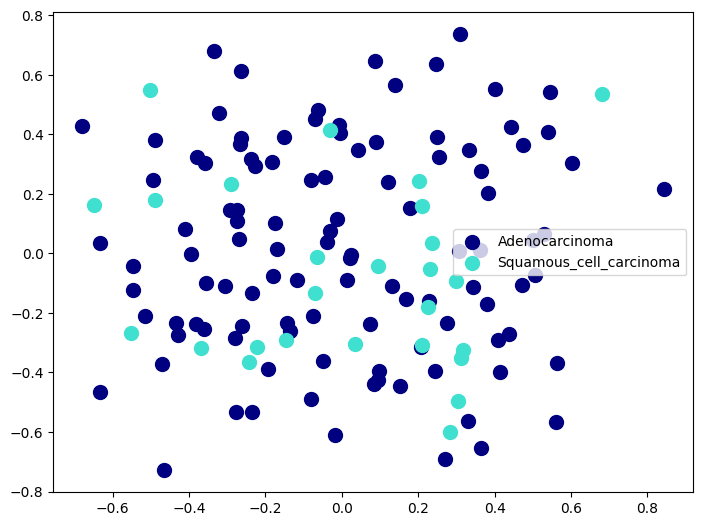

In [16]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
import pandas as pd

fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

# Type of tumor
Adenocarcinoma = histrology[histrology['Histology']=="Adenocarcinoma"]['uid'].values
Squamous_cell_carcinoma= histrology[histrology['Histology']=="Squamous cell carcinoma"]['uid'].values

plt.scatter(pos_MDS[Adenocarcinoma, 0], pos_MDS[Adenocarcinoma, 1], color='navy', alpha=1.0, s=s, lw=1, label='Adenocarcinoma')
plt.scatter(pos_MDS[Squamous_cell_carcinoma, 0], pos_MDS[Squamous_cell_carcinoma, 1], color='turquoise', alpha=1.0, s=s, lw=1, label='Squamous_cell_carcinoma')
# plt.scatter(pos[astrocytoma, 0], pos[astrocytoma, 1], color='darkorange', alpha=0.5, s=s, lw=1, label='astrocytoma')

plt.legend(scatterpoints=1, loc=5, shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0
plt.show()

### PCA

/tmp/ipykernel_4184355/460703106.py:21: RuntimeWarning: divide by zero encountered in divide
  similarities = similarities.max() / similarities * 100


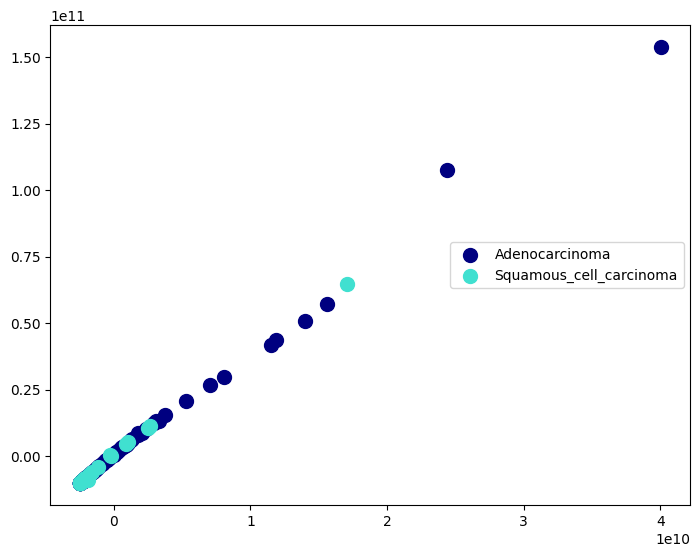

In [17]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm


fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

# Type of tumor
Adenocarcinoma = histrology[histrology['Histology']=="Adenocarcinoma"]['uid'].values
Squamous_cell_carcinoma= histrology[histrology['Histology']=="Squamous cell carcinoma"]['uid'].values

plt.scatter(pos_PCA[Adenocarcinoma, 0], pos_PCA[Adenocarcinoma, 1], color='navy', alpha=1.0, s=s, lw=1, label='Adenocarcinoma')
plt.scatter(pos_PCA[Squamous_cell_carcinoma, 0], pos_PCA[Squamous_cell_carcinoma, 1], color='turquoise', alpha=1.0, s=s, lw=1, label='Squamous_cell_carcinoma')
# plt.scatter(pos[astrocytoma, 0], pos[astrocytoma, 1], color='darkorange', alpha=0.5, s=s, lw=1, label='astrocytoma')

plt.legend(scatterpoints=1, loc=5, shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0
plt.show()

## With Type of Survial Status

### MDS

/tmp/ipykernel_4184355/822239636.py:21: RuntimeWarning: divide by zero encountered in divide
  similarities = similarities.max() / similarities * 100


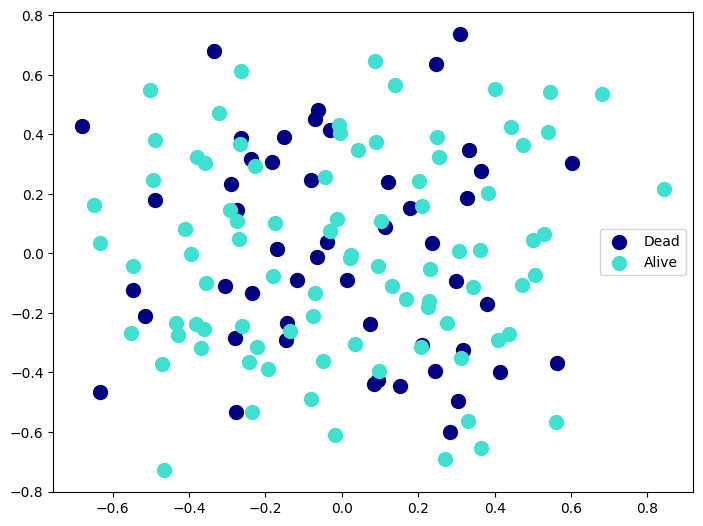

In [18]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm


fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

# survival status
dead = survival_status[survival_status['labels']==1]['uid'].values
alive = survival_status[survival_status['labels']==0]['uid'].values

plt.scatter(pos_MDS[dead, 0], pos_MDS[dead, 1], color='navy', alpha=1.0, s=s, lw=1, label='Dead')
plt.scatter(pos_MDS[alive, 0], pos_MDS[alive, 1], color='turquoise', alpha=1.0, s=s, lw=1, label='Alive')
# plt.scatter(pos[astrocytoma, 0], pos[astrocytoma, 1], color='darkorange', alpha=0.5, s=s, lw=1, label='astrocytoma')

plt.legend(scatterpoints=1, loc=5, shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0
plt.show()

### PCA

/tmp/ipykernel_4184355/983176487.py:21: RuntimeWarning: divide by zero encountered in divide
  similarities = similarities.max() / similarities * 100


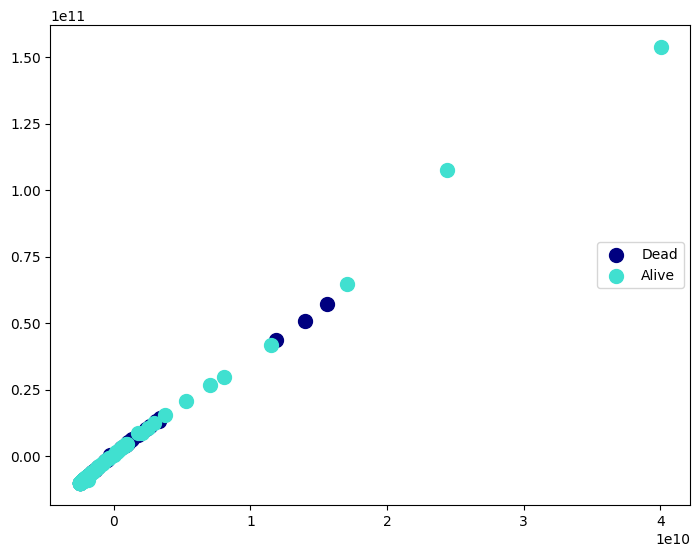

In [19]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm


fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

# survival status
dead = survival_status[survival_status['labels']==1]['uid'].values
alive = survival_status[survival_status['labels']==0]['uid'].values

plt.scatter(pos_PCA[dead, 0], pos_PCA[dead, 1], color='navy', alpha=1.0, s=s, lw=1, label='Dead')
plt.scatter(pos_PCA[alive, 0], pos_PCA[alive, 1], color='turquoise', alpha=1.0, s=s, lw=1, label='Alive')
# plt.scatter(pos[astrocytoma, 0], pos[astrocytoma, 1], color='darkorange', alpha=0.5, s=s, lw=1, label='astrocytoma')

plt.legend(scatterpoints=1, loc=5, shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0
plt.show()

## Plot features as a heatmap

In [149]:
# data_labels = pd.read_csv("/data4/hrehman/Clinical Data/NSCLCR01Radiogenomic_DATA_LABELS_2018-05-22_1500-shifted.csv")
# data_labels = data_labels['']
# types = np.array(csv['Histology'])

In [150]:
# import pandas as pd
# import seaborn as sns

# # type of each tumor
# types =['meningioma', 'meningioma', 'meningioma', 'glioma', 'astrocytoma', 'glioma', 'astrocytoma', 'astrocytoma', 'astrocytoma', 'glioma']
# types = 

# # Construct a pandas dataframe from the samples
# d = pd.DataFrame(data=samples, columns=feature_names, index=types)

# corr = d.corr()

# # Set up the matplotlib figure, make it big!
# f, ax = plt.subplots(figsize=(15, 10))

# # Draw the heatmap using seaborn
# sns.heatmap(corr, vmax=.8, square=True)

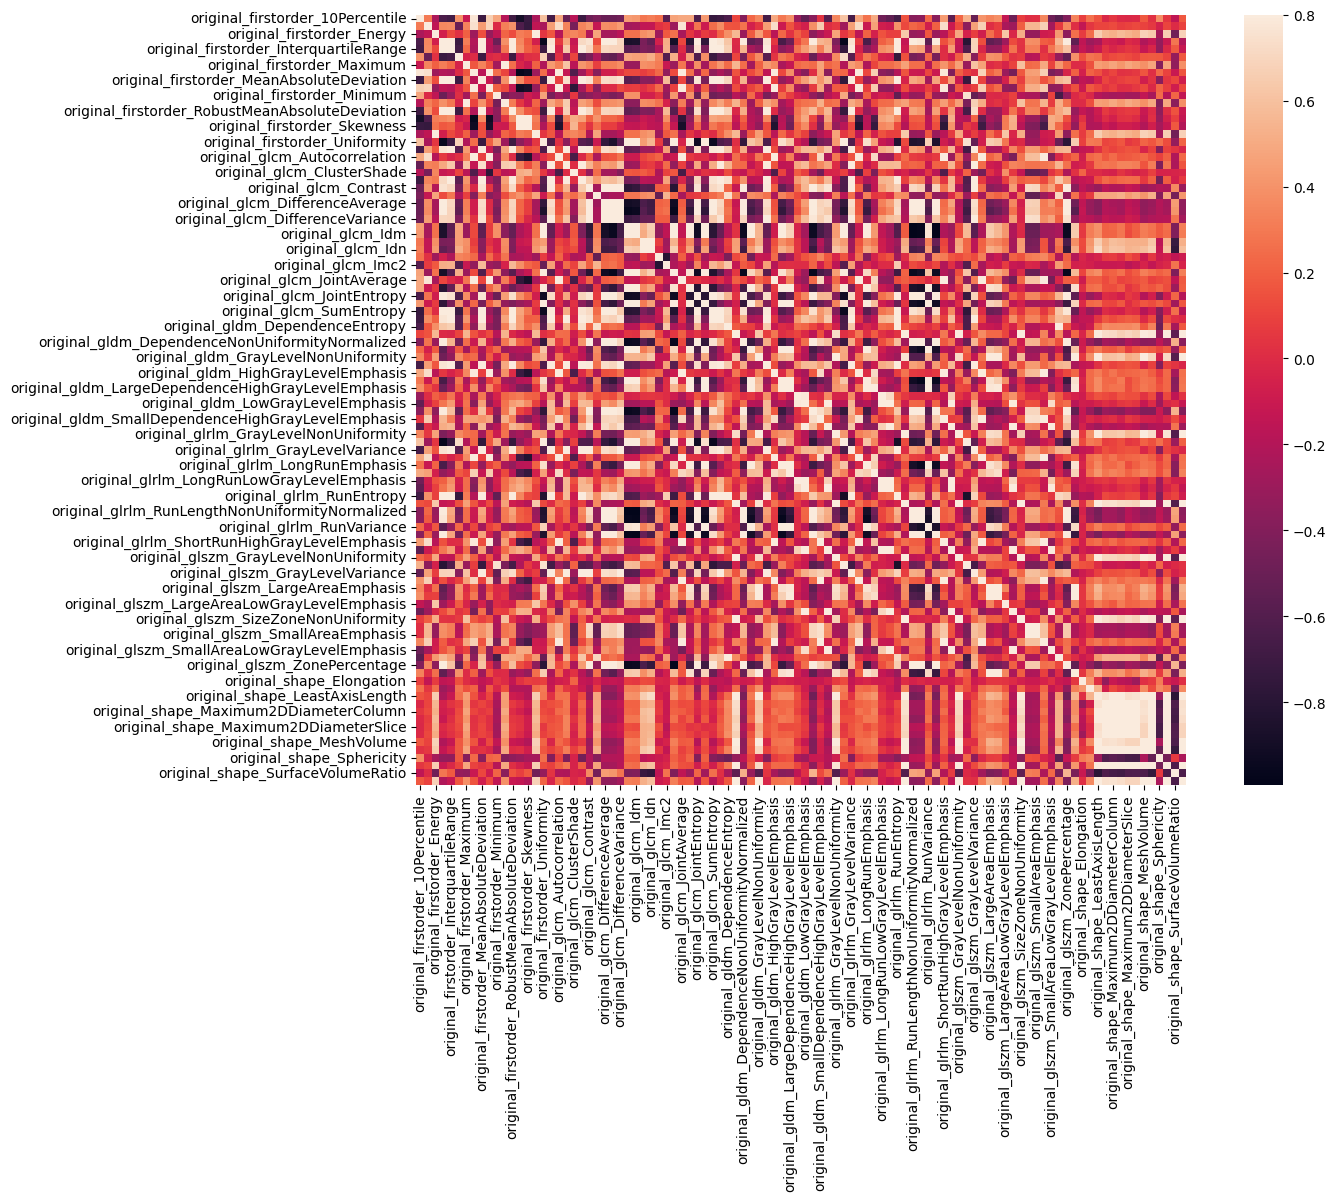

In [20]:
# Construct a pandas dataframe from the samples
d = pandas.DataFrame(data=samples, columns=feature_names)
corr = d.corr()

# Set up the matplotlib figure, make it big!
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sns.heatmap(corr, vmax=.8, square=True)
plt.show()

### Cluster the heatmap

/home/hrehman/radiomics_venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/hrehman/radiomics_venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


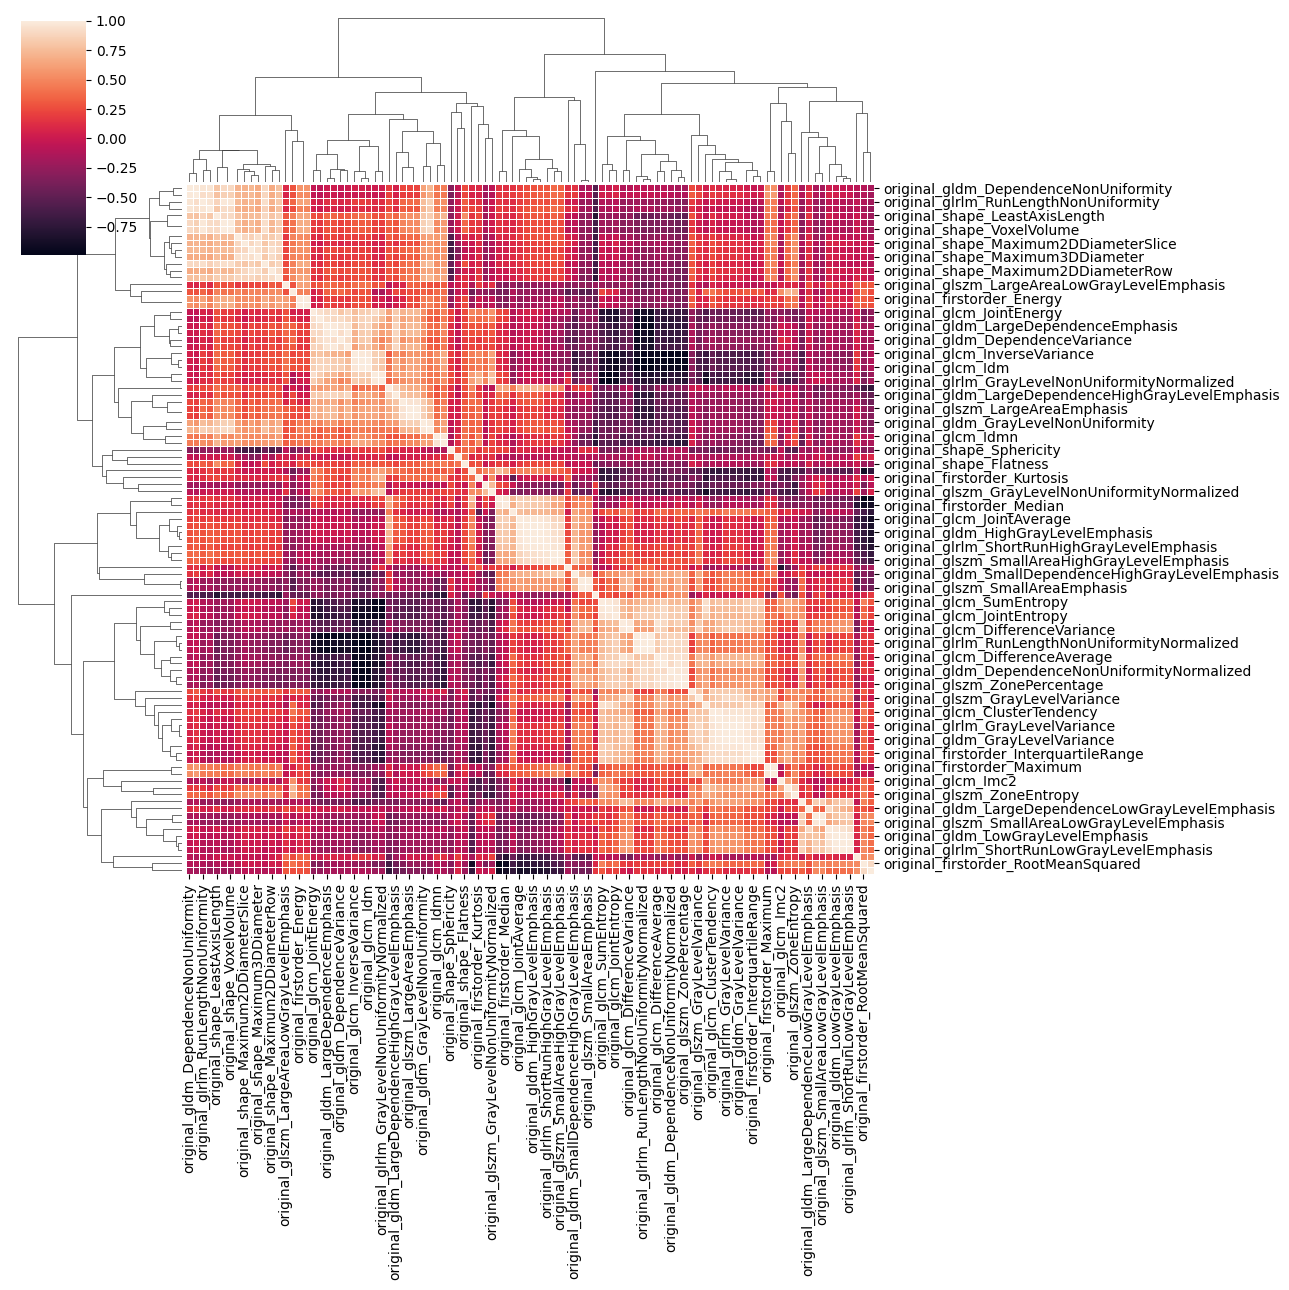

In [21]:
# Choose a subset of features for clustering
dd = d.iloc[:,:]

pp = sns.clustermap(dd.corr(), linewidths=.5, figsize=(13,13))
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)

### PCP

In [22]:
survival_status

Survival Status  Case ID  uid  labels
49            Alive  R01-001    0       0
50            Alive  R01-002    1       0
51            Alive  R01-003    2       0
52            Alive  R01-004    3       0
53             Dead  R01-005    4       1
..              ...      ...  ...     ...
189           Alive  R01-141  132       0
190           Alive  R01-142  133       0
192           Alive  R01-144  134       0
193           Alive  R01-145  135       0
194            Dead  R01-146  136       1

[137 rows x 4 columns]

In [248]:
d['uid'] = np.arange(len(config_patinets))
d['survival_status'] = list(survival_status['labels'])
d.columns[10:50]

Index(['original_firstorder_Minimum', 'original_firstorder_Range',
       'original_firstorder_RobustMeanAbsoluteDeviation',
       'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness',
       'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity',
       'original_firstorder_Variance', 'original_glcm_Autocorrelation',
       'original_glcm_ClusterProminence', 'original_glcm_ClusterShade',
       'original_glcm_ClusterTendency', 'original_glcm_Contrast',
       'original_glcm_Correlation', 'original_glcm_DifferenceAverage',
       'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance',
       'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Idmn',
       'original_glcm_Idn', 'original_glcm_Imc1', 'original_glcm_Imc2',
       'original_glcm_InverseVariance', 'original_glcm_JointAverage',
       'original_glcm_JointEnergy', 'original_glcm_JointEntropy',
       'original_glcm_MaximumProbability', 'original_glcm_SumEntropy',
       'origi

In [25]:
import numpy as np
count = 0
samples_full_data = np.zeros((len(config_patinets)+1,len(feature_names)+1))
for patient in patients:
    if str(patient+'.txt') in config_patinets:
        a = np.array([])
        for feature_name in feature_names:
            a = np.append(a, features[patient][feature_name])
        a = np.append(a,int(patient.strip('-')[-1]))
        samples_full_data[count,:] = a
        count +=1
# May have NaNs
samples_full_data = np.nan_to_num(samples_full_data)

In [26]:
survival_status

Survival Status  Case ID  uid  labels
49            Alive  R01-001    0       0
50            Alive  R01-002    1       0
51            Alive  R01-003    2       0
52            Alive  R01-004    3       0
53             Dead  R01-005    4       1
..              ...      ...  ...     ...
189           Alive  R01-141  132       0
190           Alive  R01-142  133       0
192           Alive  R01-144  134       0
193           Alive  R01-145  135       0
194            Dead  R01-146  136       1

[137 rows x 4 columns]

In [27]:
survival_status['Case ID']

49     R01-001
50     R01-002
51     R01-003
52     R01-004
53     R01-005
        ...   
189    R01-141
190    R01-142
192    R01-144
193    R01-145
194    R01-146
Name: Case ID, Length: 137, dtype: object

In [28]:
all_features = feature_names + ['remove']
data = pandas.DataFrame(data=samples_full_data, columns=all_features)
data = data.iloc[:-1 , :]
data = data.iloc[:, :-1]
data['labels'] = survival_status['labels'].values
data['Patient_id'] = survival_status['Case ID'].values
data['survival_status'] = survival_status['Survival Status'].values

In [29]:
import plotly.express as px
df = data
fig = px.parallel_coordinates(df,
                              dimensions=['labels','original_shape_Sphericity', 'original_shape_SurfaceArea', 'original_shape_VoxelVolume',
                                          'original_shape_SurfaceVolumeRatio'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)
fig.show()

In [249]:
import plotly.express as px
df = data
fig = px.parallel_coordinates(df,
                              dimensions=['labels','original_glcm_InverseVariance', 'original_glcm_JointAverage',
       'original_glcm_JointEnergy', 'original_glcm_JointEntropy',
       'original_glcm_MaximumProbability', 'original_glcm_SumEntropy',
       'original_glcm_SumSquares', 'original_gldm_DependenceEntropy'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)
fig.show()

Show the distribution of different variables

In [30]:
# make a cleaner vefirst_colson
clean_df = df[feature_names].copy()
# clean_df.columns = [
#     ' '.join(c_col.split('original_')[-1].split('_')) 
#     for c_col in feature_names
# ]
clean_col_names = clean_df.columns[len(feature_names):]
# fix some of the artifacts from the radiomics tool
obj_cols = clean_df[clean_col_names].select_dtypes(['object']).columns.tolist()
for c_col in obj_cols:
    clean_df[c_col] = clean_df[c_col].map(lambda x: float(x))
clean_df.to_csv('clean_radiomics_table.csv', index=False)
clean_df.sample(3)

original_firstorder_10Percentile  original_firstorder_90Percentile   
58                            -513.8                             127.0  \
97                            -936.0                            -756.0   
11                            -251.4                              84.0   

    original_firstorder_Energy  original_firstorder_Entropy   
58                1.385180e+08                     5.166209  \
97                1.571605e+10                     3.564444   
11                1.154878e+08                     3.967399   

    original_firstorder_InterquartileRange  original_firstorder_Kurtosis   
58                                   314.0                      3.785637  \
97                                    76.0                     24.759615   
11                                   113.0                      7.452051   

    original_firstorder_Maximum  original_firstorder_Mean   
58                        467.0               -125.958509  \
97                        226.0               -846.421739   
11                        202.0                -32.347522   

    original_firstorder_MeanAbsoluteDeviation  original_firstorder_Median   
58                                 204.318115                       -48.0  \
97                                  74.498329                      -878.0   
11                                 105.465874                        19.0   

    ...  original_shape_Maximum2DDiameterColumn   
58  ...                               23.194827  \
97  ...                               57.974132   
11  ...                               25.709920   

    original_shape_Maximum2DDiameterRow   
58                            19.416488  \
97                            65.000000   
11                            26.832816   

    original_shape_Maximum2DDiameterSlice  original_shape_Maximum3DDiameter   
58                              24.207437                         25.019992  \
97                              67.779053                         67.779053   
11                              28.178006                         32.310989   

    original_shape_MeshVolume  original_shape_MinorAxisLength   
58                1637.958333                       15.503708  \
97               21254.500000                       40.835295   
11                4970.041667                       18.396604   

    original_shape_Sphericity  original_shape_SurfaceArea   
58                   0.578965                 1160.646777  \
97                   0.419990                 8835.112525   
11                   0.678960                 2074.339203   

    original_shape_SurfaceVolumeRatio  original_shape_VoxelVolume  
58                           0.708594                      1663.0  
97                           0.415682                     21390.0  
11                           0.417369                      5004.0  

[3 rows x 100 columns]

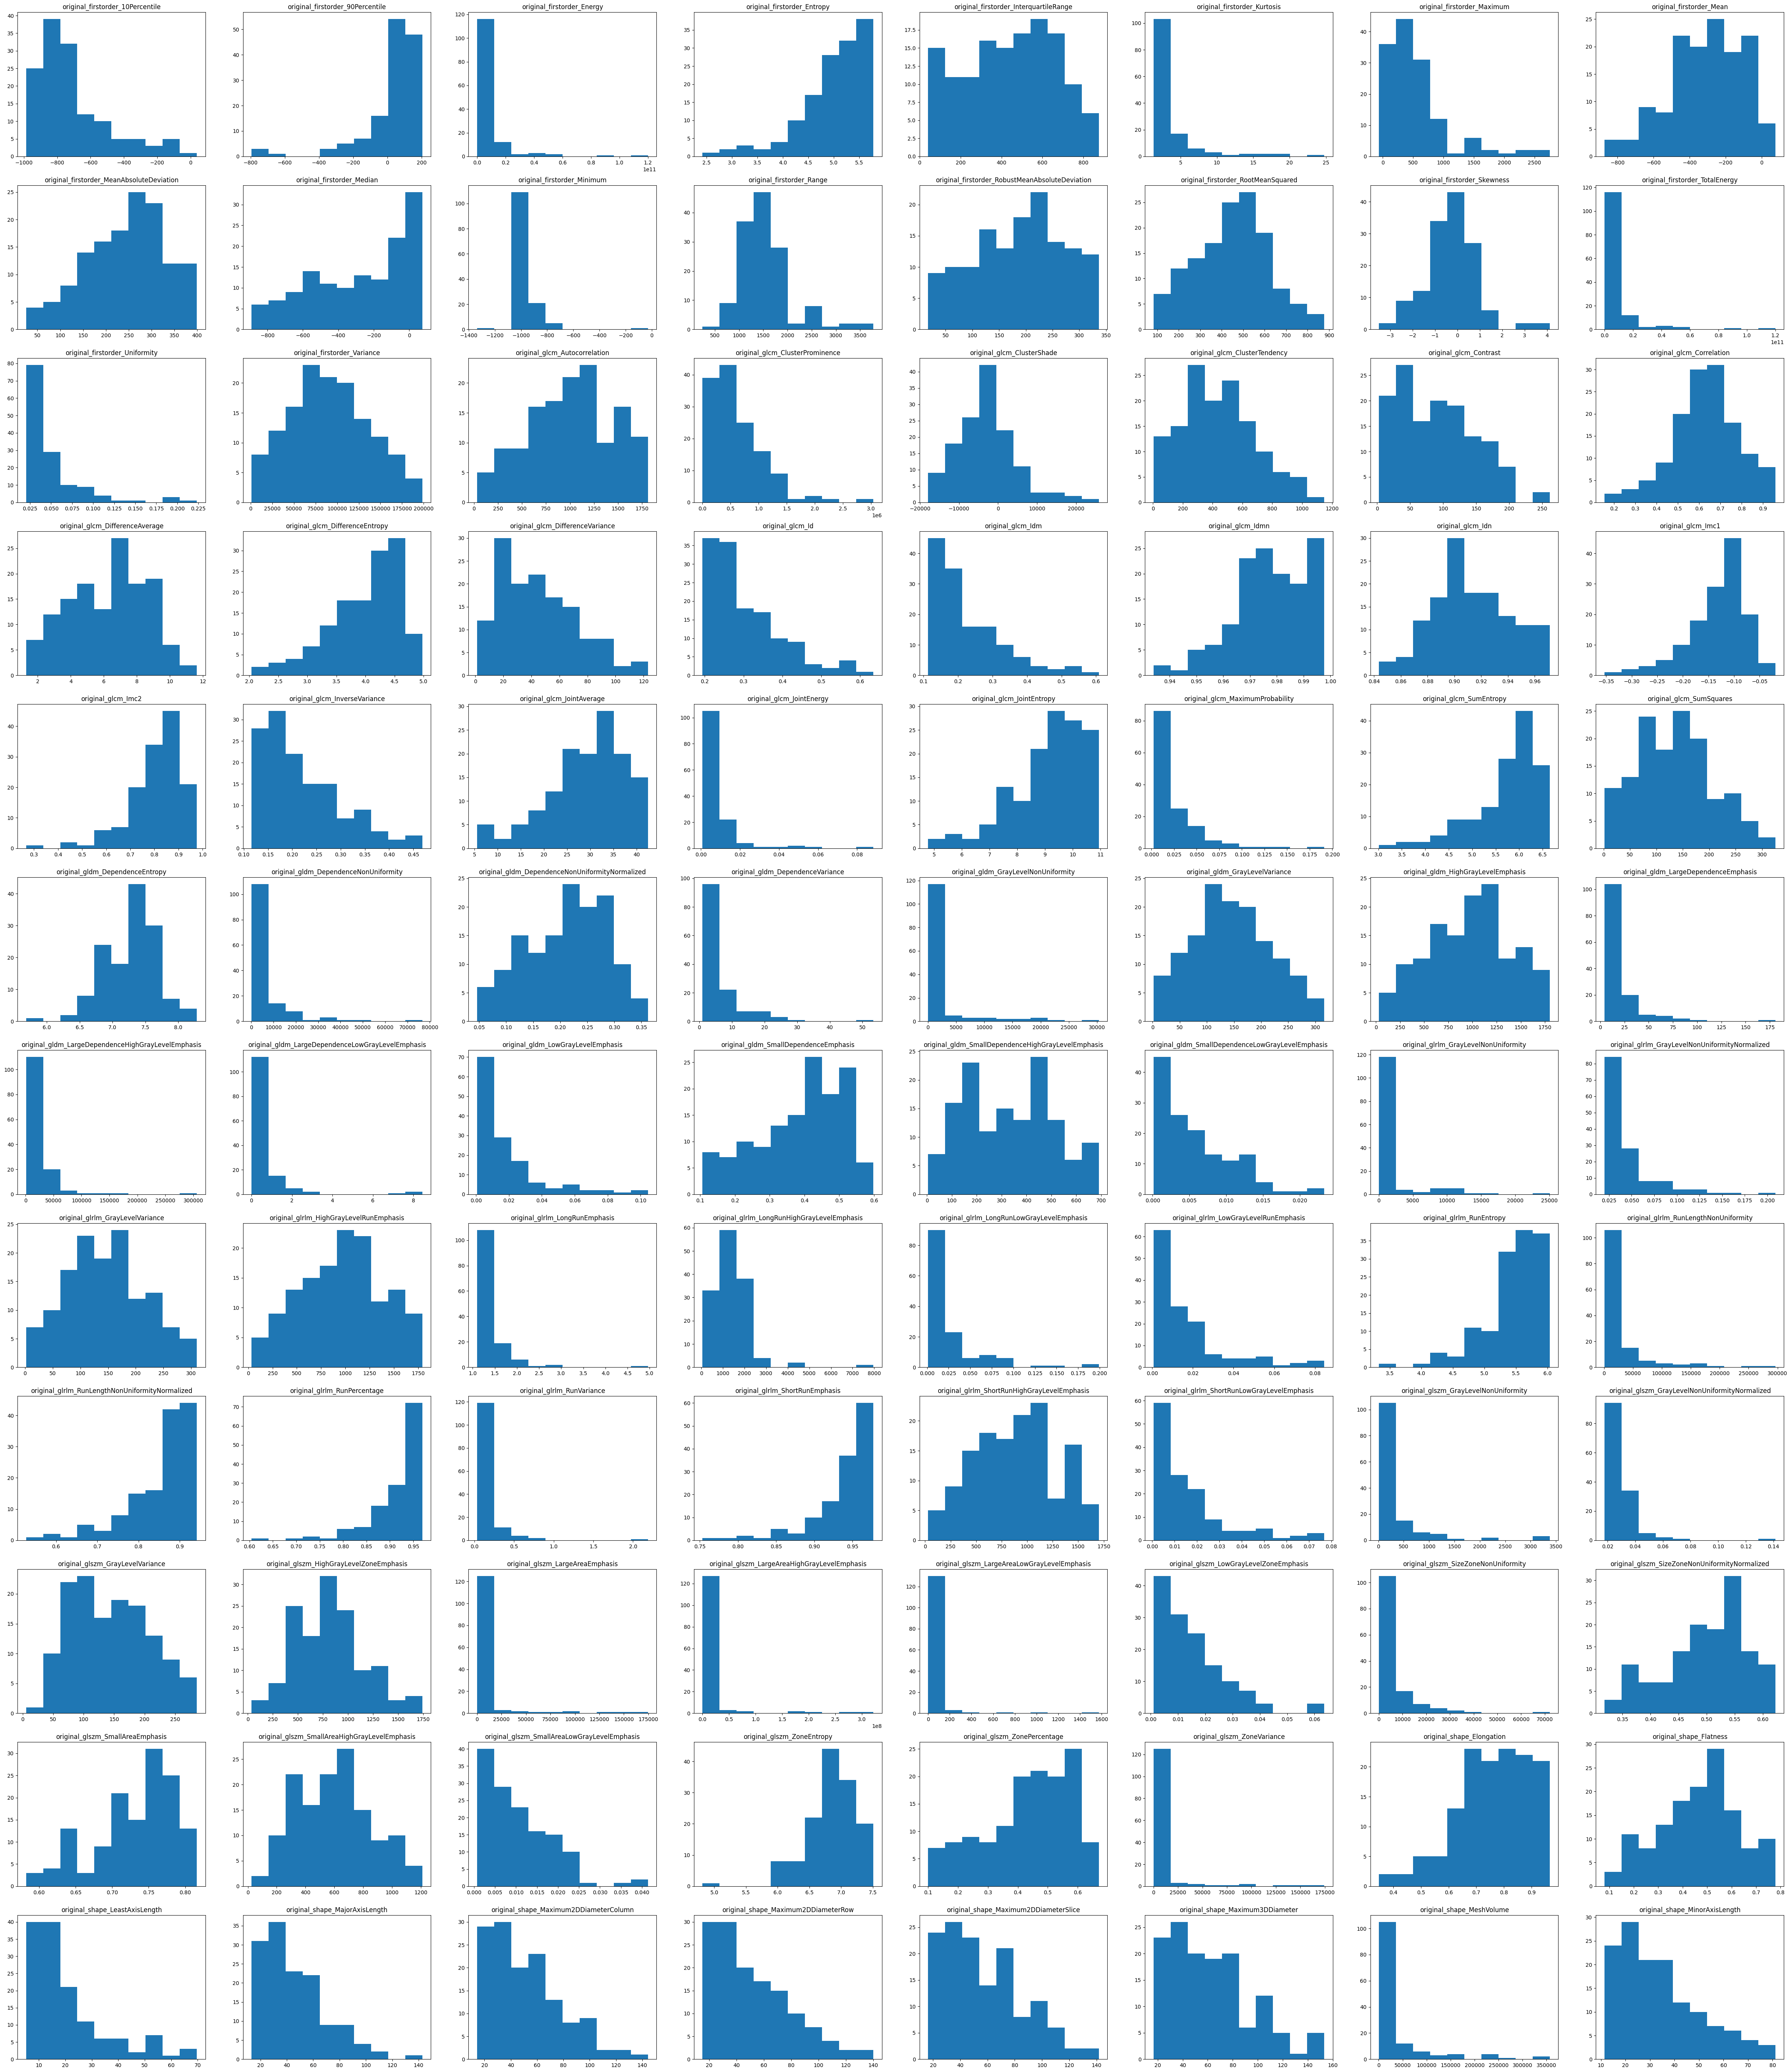

In [162]:
fig, m_axs = plt.subplots(12, 8, figsize=(60, 70))
for c_ax, c_var in zip(m_axs.flatten(), feature_names):
    c_ax.hist(clean_df[c_var].values, bins=10)
    c_ax.set_title('\n'.join(c_var.split(' ')))
fig.savefig('all_metrics.png')

# Modeling

#### RF

In [251]:
def RF_CV(X_std,y):
		RF_xy_trainlist = []
		RF_xy_testlist = []
		# dataset
		X, y = X_std, y
		# configure the cross-validation procedure
		cv_outer = KFold(n_splits=20, shuffle=True, random_state=1)
		# enumerate splits
		outer_results = list()
		i = 0
		for train_ix, test_ix in cv_outer.split(X):
			# split data
			X_train, X_test = X[train_ix, :], X[test_ix, :]
			y_train, y_test = y[train_ix], y[test_ix]
			RF_xy_trainlist.append([X_train,y_train ])
			RF_xy_testlist.append([X_test, y_test])
			# configure the cross-validation procedure
			cv_inner = KFold(n_splits=2, shuffle=True, random_state=1)
			# define the model
			model = RandomForestClassifier(random_state=1)
			# define search space
			space = dict()
			space['n_estimators'] = [10, 100, 500]
			space['min_samples_leaf'] = [5,10,15,20]
			space['criterion'] = ["gini","entropy","log_loss"]
			# space['max_features'] = [10,15,20]
			
			# define search
			search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
			# execute search
			result = search.fit(X_train, y_train)
			# get the best performing model fit on the whole training set
			best_model = result.best_estimator_
			# evaluate model on the hold out dataset
			yhat = best_model.predict(X_test)
			# evaluate the model
			acc = accuracy_score(y_test, yhat)
			# store the result
			outer_results.append(acc)
			# report progress
			print(i,'>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
			i+=1
		# summarize the estimated performance of the model
		print('Accuracy: %.3f (%.3f)' % (statistics.mean(outer_results), statistics.stdev(outer_results)))
		return RF_xy_testlist,RF_xy_trainlist
def RandomForest_ROC(X_std, y ,criterion,n_estimators,min_samples_leaf):
        forest = RandomForestClassifier(bootstrap=True,criterion=criterion,oob_score=True,n_jobs=-1,n_estimators=n_estimators,min_samples_leaf=min_samples_leaf,random_state=1,class_weight='balanced')
        cv = StratifiedKFold(n_splits=10)
        classifier = forest
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        i = 0
        for train, test in cv.split(X_std, y):
            probas_ = classifier.fit(X_std[train], y[train]).predict_proba(X_std[test])
            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
            i += 1
        return tprs,aucs,mean_fpr,forest

#### SVM

In [260]:

def SVM_CV(X_std, y):
		# dataset
		X, y = X_std, y
		xy_trainlist = []
		xy_testlist = []
		# configure the cross-validation procedure
		cv_outer = KFold(n_splits=20, shuffle=True, random_state=1)
		# enumerate splits
		outer_results = list()
		i = 0
		for train_ix, test_ix in cv_outer.split(X):
			# split data
			X_train, X_test = X[train_ix, :], X[test_ix, :]
			y_train, y_test = y[train_ix], y[test_ix]
			xy_trainlist.append([X_train,y_train ])
			xy_testlist.append([X_test, y_test])
			# configure the cross-validation procedure
			cv_inner = KFold(n_splits=2, shuffle=True, random_state=1)
			# define the model
			model = SVC(random_state=1)
			# define search space
			space = dict()
			space['kernel'] = ["poly", "rbf", "sigmoid"]
			# space['gamma'] = ["scale","auto"]
			space['C'] = [1,5,10,50]
			space["decision_function_shape"] = ['ovo','ovr']
			
			# define search
			search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True,return_train_score=True)
			# execute search
			result = search.fit(X_train, y_train)
			# get the best performing model fit on the whole training set
			best_model = result.best_estimator_
			# evaluate model on the hold out dataset
			yhat = best_model.predict(X_test)
			# evaluate the model
			acc = accuracy_score(y_test, yhat)
			# store the result
			outer_results.append(acc)
			# report progress
			print(i,'>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
			i+=1
		# summarize the estimated performance of the model
		print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))
		return xy_testlist , xy_trainlist
def SVM_ROC(X_std, y,C,kernel,decision_function_shape):
    svm = SVC(kernel=kernel, C=C,shrinking=False,probability=True,decision_function_shape=decision_function_shape,random_state=1)
    cv = StratifiedKFold(n_splits=10)
    classifier = svm
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    for train, test in cv.split(X_std, y):
        probas_ = classifier.fit(X_std[train], y[train]).predict_proba(X_std[test])
        # clf.score(X_test, y_test)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    return tprs,aucs,mean_fpr,svm

#### without Feature Selection

In [250]:
def all_features():
        dataset_all_features = data.copy()
        class_mapping = {label: idx for idx, label in enumerate(np.unique(dataset_all_features['survival_status']))}
        class_mapping
        dataset_all_features['survival_status'] = dataset_all_features['survival_status'].map(class_mapping)
        y = LabelEncoder().fit_transform(dataset_all_features['survival_status'].values)
        X = dataset_all_features.iloc[:,0:len(dataset_all_features.columns)-3].values
        print(y.shape)
        print(X.shape)
        feat_labels = dataset_all_features.columns[0:len(dataset_all_features.columns)-3]
        return X,y,dataset_all_features

##### Random Forest

In [259]:
X,y,dataset_all_features  = all_features()
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)
print("X shape",X_std.shape)
RF_xy_testlist,RF_xy_trainlist = RF_CV(X_std,y)

(137,)
(137, 100)
X shape (137, 100)
0 >acc=0.571, est=0.646, cfg={'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 10}
1 >acc=0.857, est=0.638, cfg={'criterion': 'entropy', 'min_samples_leaf': 10, 'n_estimators': 100}
2 >acc=0.429, est=0.608, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 100}
3 >acc=0.429, est=0.654, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 10}
4 >acc=0.429, est=0.662, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 10}
5 >acc=0.714, est=0.638, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 10}
6 >acc=0.429, est=0.631, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 10}
7 >acc=0.571, est=0.638, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 100}
8 >acc=0.429, est=0.677, cfg={'criterion': 'entropy', 'min_samples_leaf': 10, 'n_estimators': 500}
9 >acc=0.571, est=0.662, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 10}
10 >

The optimal settings that we selected are 


11 >acc=0.857, est=0.646, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 100}

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and w

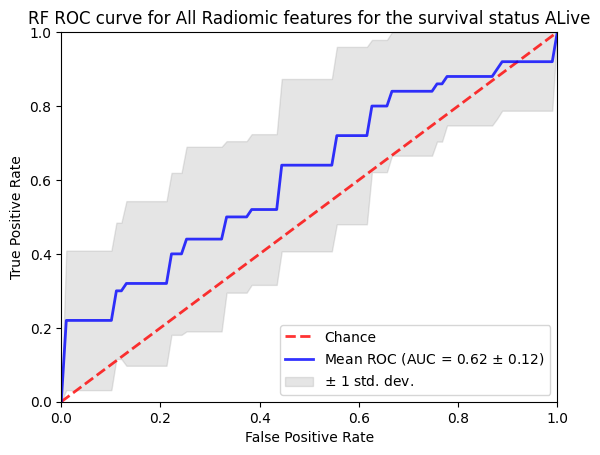

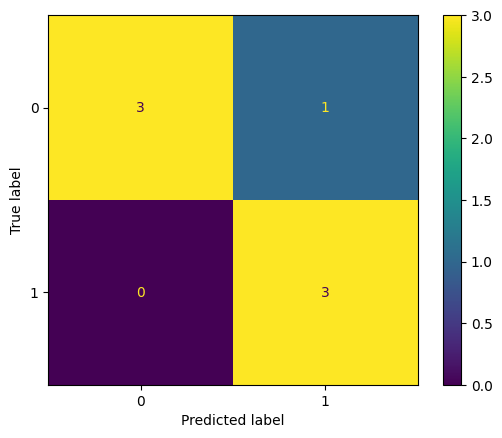

In [261]:
tprs,aucs,mean_fpr,forest = RandomForest_ROC(X_std,y,criterion='gini',n_estimators=100,min_samples_leaf=20)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC curve for All Radiomic features for the survival status ALive')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(forest, RF_xy_testlist[11][0], RF_xy_testlist[11][1])

##### SVM

In [263]:
X,y,dataset_all_features  = all_features()
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)
print("X shape",X_std.shape)
xy_testlist,xy_trainlist = SVM_CV(X_std,y)

(137,)
(137, 100)
X shape (137, 100)
0 >acc=0.714, est=0.631, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
1 >acc=0.857, est=0.631, cfg={'C': 10, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
2 >acc=0.714, est=0.638, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
3 >acc=0.429, est=0.669, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
4 >acc=0.571, est=0.654, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
5 >acc=0.714, est=0.646, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
6 >acc=0.857, est=0.677, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
7 >acc=0.571, est=0.669, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
8 >acc=0.429, est=0.669, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
9 >acc=0.571, est=0.677, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
10 >acc=0.571, est=0.631, cfg={'C': 1, 'decision_function_shape':

/tmp/ipykernel_4184355/4210827970.py:59: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/4210827970.py:59: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/4210827970.py:59: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/4210827970.py:59: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/4210827970.py:59: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/4210827970.py:59: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/4210827970.py:59: DeprecationWarning:

scipy.interp is deprecated and w

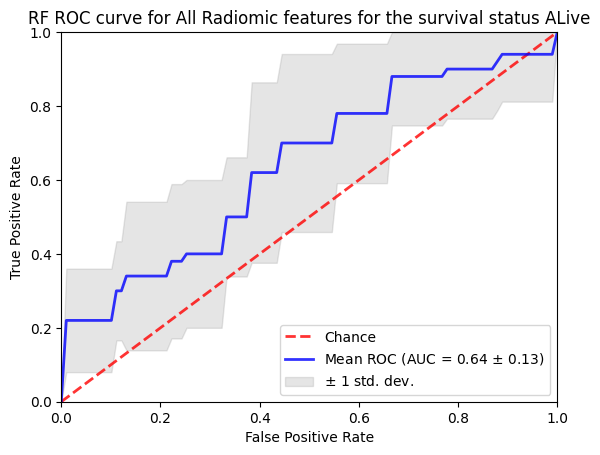

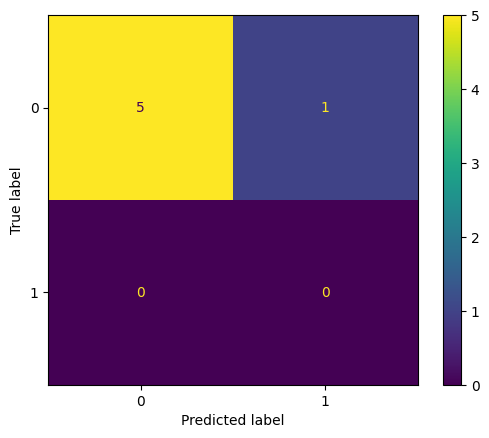

In [274]:
tprs,aucs,mean_fpr,svm = SVM_ROC(X_std,y , C= 1, kernel = 'sigmoid' , decision_function_shape = 'ovo')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC curve for All Radiomic features for the survival status ALive')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(svm, xy_testlist[18][0], xy_testlist[18][1])

#### Feature Selection with threshold

After analysing the features from the maps above, we will now clean the dataframe with highly correlated variable since they will cause strong assumptions.
Now to do so , we have different techniques , proposed following

In [285]:
def threshold_feature_selection(data):
    data_with_selected_Features1 = data.copy()
    # get upper triangle of correlation matrix
    corr_matrix =  corr
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool8))
    # find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
    # drop highly correlated features
    data_with_selected_Features1.drop(to_drop, axis=1, inplace=True)
    data_with_selected_Features1.info()
    df_drop = data_with_selected_Features1.dropna(axis=0)
    df_drop.replace([np.inf, -np.inf],np.nan,inplace=True)
    df_drop.fillna(0,inplace=True)
    return df_drop

In [286]:
threshold_feature_selection(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 32 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   original_firstorder_10Percentile                    137 non-null    float64
 1   original_firstorder_90Percentile                    137 non-null    float64
 2   original_firstorder_Energy                          137 non-null    float64
 3   original_firstorder_Entropy                         137 non-null    float64
 4   original_firstorder_Kurtosis                        137 non-null    float64
 5   original_firstorder_Maximum                         137 non-null    float64
 6   original_firstorder_Mean                            137 non-null    float64
 7   original_firstorder_Minimum                         137 non-null    float64
 8   original_firstorder_RootMeanSquared                 137 non-null    float64
 9  

original_firstorder_10Percentile  original_firstorder_90Percentile   
0                              -443.0                              41.0  \
1                              -386.1                              38.0   
2                              -324.4                             106.0   
3                              -501.2                             148.0   
4                              -154.0                              51.0   
..                                ...                               ...   
132                            -855.0                             114.0   
133                            -717.0                              94.0   
134                            -838.0                              37.0   
135                            -913.0                              72.0   
136                            -539.0                             109.0   

     original_firstorder_Energy  original_firstorder_Entropy   
0                  1.552086e+08                     4.496936  \
1                  8.860778e+07                     4.192986   
2                  4.174656e+07                     4.332427   
3                  1.084852e+08                     4.833568   
4                  2.035543e+08                     3.365276   
..                          ...                          ...   
132                3.098198e+09                     5.647720   
133                3.852615e+09                     5.490919   
134                2.283232e+09                     5.456589   
135                2.706531e+10                     5.227012   
136                1.719157e+10                     4.454185   

     original_firstorder_Kurtosis  original_firstorder_Maximum   
0                        2.964832                        154.0  \
1                        4.442666                        144.0   
2                        4.758523                        290.0   
3                        4.179931                        366.0   
4                       10.191594                        391.0   
..                            ...                          ...   
132                      1.741596                        827.0   
133                      1.921837                        467.0   
134                      1.805940                        495.0   
135                      2.610789                       1350.0   
136                      3.435458                       1011.0   

     original_firstorder_Mean  original_firstorder_Minimum   
0                 -139.272894                       -812.0  \
1                 -105.572558                       -829.0   
2                  -42.965257                       -815.0   
3                  -74.679379                      -1024.0   
4                  -25.891429                       -783.0   
..                        ...                          ...   
132               -326.975698                      -1024.0   
133               -276.532241                      -1023.0   
134               -457.097741                      -1024.0   
135               -528.989135                      -1024.0   
136                -85.450186                       -945.0   

     original_firstorder_RootMeanSquared  original_firstorder_Uniformity  ...   
0                             238.920446                        0.063359  ...  \
1                             203.009652                        0.082164  ...   
2                             177.568667                        0.073279  ...   
3                             264.813482                        0.051739  ...   
4                             110.652020                        0.151074  ...   
..                                   ...                             ...  ...   
132                           498.489716                        0.022065  ...   
133                           412.496662                        0.024132  ...   
134                           569.533886                        0.02

##### Random Forest

In [287]:
df_drop = threshold_feature_selection(data)
class_mapping = {label: idx for idx, label in enumerate(np.unique(df_drop['survival_status']))}
class_mapping
df_drop['survival_status'] = df_drop['survival_status'].map(class_mapping)
y = LabelEncoder().fit_transform(df_drop['survival_status'].values)
X = df_drop.iloc[:,0:len(df_drop.columns)-3].values
print("Y shape" , y.shape)
print("X shape" , X.shape)
feat_labels = df_drop.columns[0:len(df_drop.columns)-3]
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)
RF_xy_testlist,RF_xy_trainlist = RF_CV(X_std,y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 32 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   original_firstorder_10Percentile                    137 non-null    float64
 1   original_firstorder_90Percentile                    137 non-null    float64
 2   original_firstorder_Energy                          137 non-null    float64
 3   original_firstorder_Entropy                         137 non-null    float64
 4   original_firstorder_Kurtosis                        137 non-null    float64
 5   original_firstorder_Maximum                         137 non-null    float64
 6   original_firstorder_Mean                            137 non-null    float64
 7   original_firstorder_Minimum                         137 non-null    float64
 8   original_firstorder_RootMeanSquared                 137 non-null    float64
 9  

The optimal settings that we selected are 


10 >acc=0.857, est=0.631, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 100}

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and w

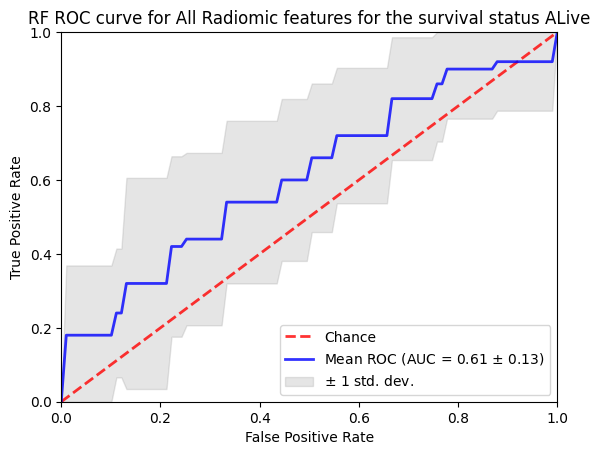

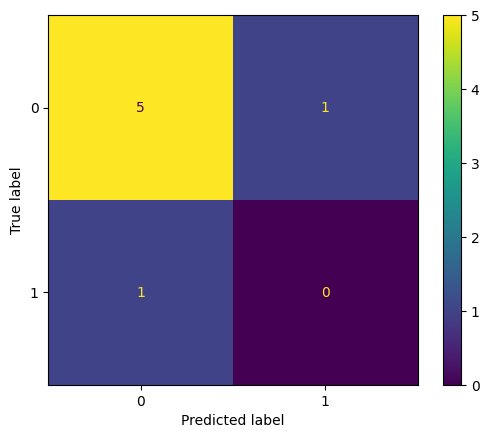

In [292]:
tprs,aucs,mean_fpr,forest = RandomForest_ROC(X_std, y , criterion='entropy',n_estimators=100,min_samples_leaf=15)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC curve for All Radiomic features for the survival status ALive')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(forest, RF_xy_testlist[1][0], RF_xy_testlist[1][1])

In [294]:
df_drop = threshold_feature_selection(data)
class_mapping = {label: idx for idx, label in enumerate(np.unique(df_drop['survival_status']))}
class_mapping
df_drop['survival_status'] = df_drop['survival_status'].map(class_mapping)
y = LabelEncoder().fit_transform(df_drop['survival_status'].values)
X = df_drop.iloc[:,0:len(df_drop.columns)-3].values
print("Y shape" , y.shape)
print("X shape" , X.shape)
feat_labels = df_drop.columns[0:len(df_drop.columns)-3]
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)
xy_testlist,xy_trainlist = SVM_CV(X_std,y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 32 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   original_firstorder_10Percentile                    137 non-null    float64
 1   original_firstorder_90Percentile                    137 non-null    float64
 2   original_firstorder_Energy                          137 non-null    float64
 3   original_firstorder_Entropy                         137 non-null    float64
 4   original_firstorder_Kurtosis                        137 non-null    float64
 5   original_firstorder_Maximum                         137 non-null    float64
 6   original_firstorder_Mean                            137 non-null    float64
 7   original_firstorder_Minimum                         137 non-null    float64
 8   original_firstorder_RootMeanSquared                 137 non-null    float64
 9  

The optimal settings that we selected are 


12 >acc=0.857, est=0.669, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}

/tmp/ipykernel_4184355/4210827970.py:59: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/4210827970.py:59: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/4210827970.py:59: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/4210827970.py:59: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/4210827970.py:59: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/4210827970.py:59: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/4210827970.py:59: DeprecationWarning:

scipy.interp is deprecated and w

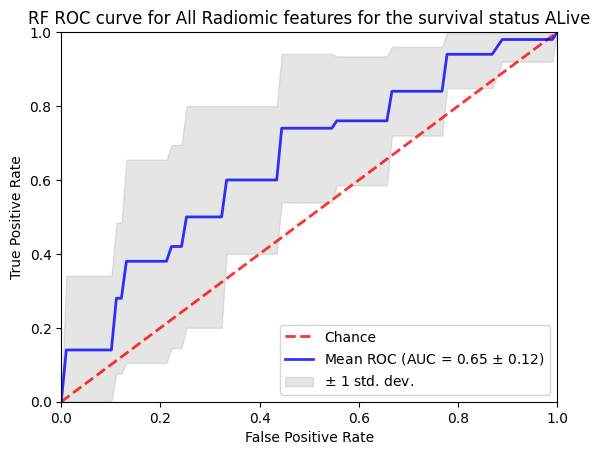

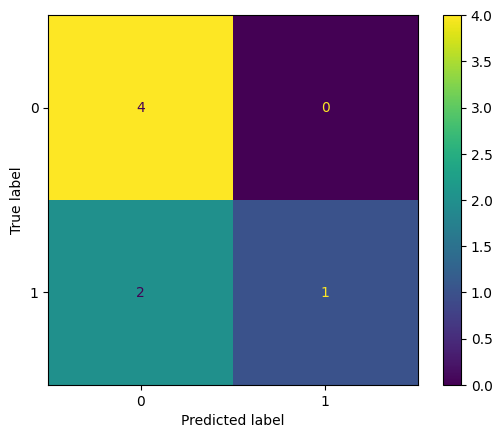

In [297]:
tprs,aucs,mean_fpr,svm = SVM_ROC(X_std,y , C= 1, kernel = 'sigmoid' , decision_function_shape = 'ovo')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC curve for All Radiomic features for the survival status ALive')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(svm, xy_testlist[5][0], xy_testlist[5][1])

#### Feature selection with LASSO

In [311]:
def lasso(data):
    X = data.iloc[:,0:len(data.columns)-3]
    y = data['labels'].values
    scaler = StandardScaler()
    scaler.fit(X)
    sel_ = SelectFromModel(
        LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))
    sel_.fit(scaler.transform(X), y)
    removed_feats = X.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
    lasso_data = X.drop(columns=removed_feats, axis = 1)
    return lasso_data , y

In [312]:
s = lasso(data)
s[0]

original_firstorder_Maximum  original_glcm_ClusterShade   
0                          154.0                -2285.722545  \
1                          144.0                -1550.034184   
2                          290.0                -1272.245157   
3                          366.0                -5332.149814   
4                          391.0                 -592.882657   
..                           ...                         ...   
132                        827.0                -7378.929982   
133                        467.0                -4279.622271   
134                        495.0                 2998.089218   
135                       1350.0                25788.848345   
136                       1011.0                -8735.489546   

     original_glcm_Imc2  original_gldm_DependenceVariance   
0              0.803272                         12.537216  \
1              0.699659                          7.084133   
2              0.760635                          5.804447   
3              0.868241                          4.029620   
4              0.552288                         15.158229   
..                  ...                               ...   
132            0.799084                          1.943188   
133            0.812747                          1.633098   
134            0.834945                          1.683760   
135            0.902429                          3.322186   
136            0.935623                         17.187802   

     original_gldm_LargeDependenceLowGrayLevelEmphasis   
0                                             0.029890  \
1                                             0.019846   
2                                             0.015880   
3                                             0.008517   
4                                             0.050188   
..                                                 ...   
132                                           0.558159   
133                                           0.013118   
134                                           0.094926   
135                                           0.265266   
136                                           0.048839   

     original_glrlm_LongRunLowGrayLevelEmphasis   
0                                      0.003367  \
1                                      0.003234   
2                                      0.002565   
3                                      0.002140   
4                                      0.002203   
..                                          ...   
132                                    0.039815   
133                                    0.003622   
134                                    0.015598   
135                                    0.025020   
136                                    0.002774   

     original_glszm_LargeAreaLowGrayLevelEmphasis  original_shape_Flatness   
0                                        0.262969                 0.544028  \
1                                        0.310598                 0.624390   
2                                        0.128019                 0.511875   
3                                        0.045259                 0.367115   
4                                       11.347724                 0.509750   
..                                            ...                      ...   
132                                      0.542136                 0.363463   
133                                      0.022581                 0.251463   
134                                      0.110446                 0.302722   
135                                     14.489349                 0.612889   
136                                     59.243342                 0.503629   

     original_shape_Maximum3DDiameter  
0                           29.189039  
1                           24.372115  
2                           23.043437  
3                           24.919872  
4                           51.584882  
..              

In [313]:
lasso_data,y = lasso(data)
stdsc = StandardScaler()
X_std = stdsc.fit_transform(lasso_data.iloc[:].values)
RF_xy_testlist,RF_xy_trainlist = RF_CV(X_std,y)

0 >acc=0.571, est=0.638, cfg={'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 10}
1 >acc=0.857, est=0.631, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 10}
2 >acc=0.286, est=0.623, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 500}
3 >acc=0.286, est=0.669, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 10}
4 >acc=0.429, est=0.646, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 10}
5 >acc=0.571, est=0.638, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 100}
6 >acc=0.571, est=0.638, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 100}
7 >acc=0.571, est=0.631, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 10}
8 >acc=0.571, est=0.669, cfg={'criterion': 'entropy', 'min_samples_leaf': 10, 'n_estimators': 10}
9 >acc=0.571, est=0.646, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 10}
10 >acc=0.714, est=0.638, cfg={'criterion': '

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and w

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



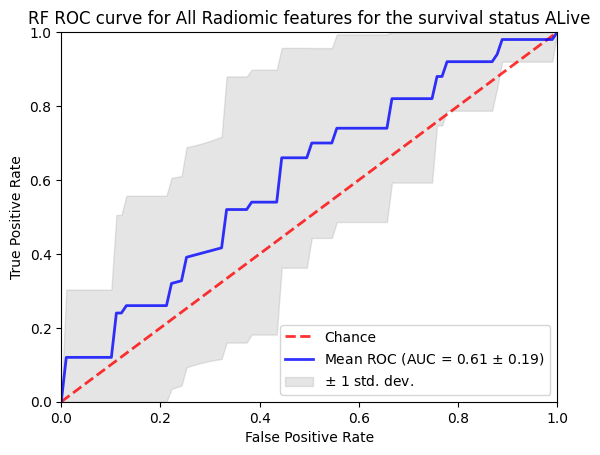

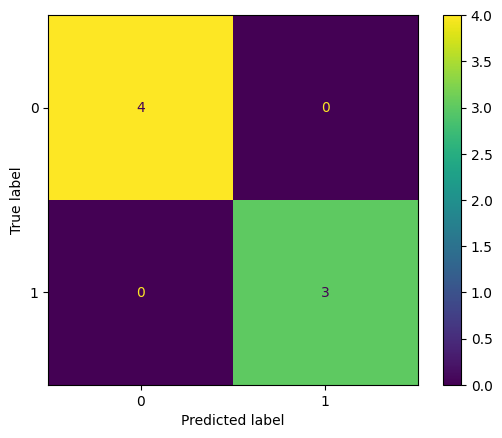

In [314]:
tprs,aucs,mean_fpr,forest = RandomForest_ROC(X_std, y , criterion='entropy',n_estimators=10,min_samples_leaf=15)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC curve for All Radiomic features for the survival status ALive')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(forest, RF_xy_testlist[11][0], RF_xy_testlist[11][1])

In [176]:
lasso_data,y = lasso(data)
stdsc = StandardScaler()
X_std = stdsc.fit_transform(lasso_data.iloc[:].values)
xy_testlist,xy_trainlist = SVM_CV(X_std,y)

0 >acc=0.857, est=0.662, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
1 >acc=0.857, est=0.654, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
2 >acc=0.714, est=0.638, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
3 >acc=0.429, est=0.677, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
4 >acc=0.429, est=0.669, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
5 >acc=0.571, est=0.646, cfg={'C': 10, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
6 >acc=0.714, est=0.654, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
7 >acc=0.571, est=0.692, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
8 >acc=0.571, est=0.685, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
9 >acc=0.571, est=0.685, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
10 >acc=0.571, est=0.654, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
11 >

/tmp/ipykernel_4184355/1822684837.py:14: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/1822684837.py:14: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/1822684837.py:14: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/1822684837.py:14: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/1822684837.py:14: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/1822684837.py:14: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/1822684837.py:14: DeprecationWarning:

scipy.interp is deprecated and w

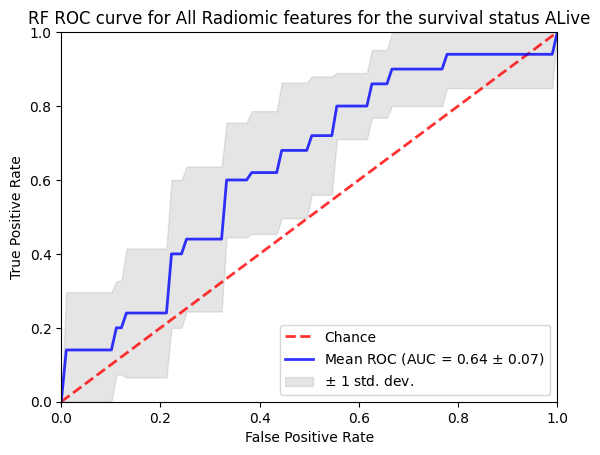

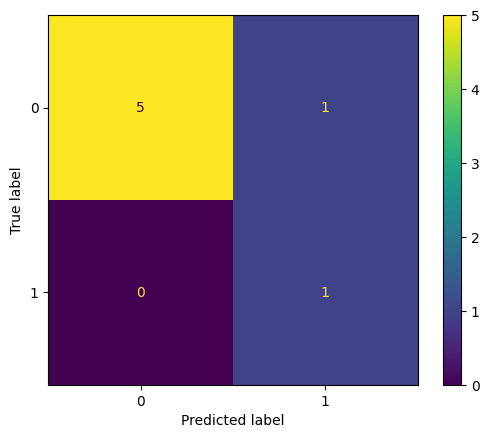

In [180]:
tprs,aucs,mean_fpr,svm = SVM_ROC(X_std,y , C= 5, kernel = 'sigmoid' , decision_function_shape = 'ovo')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC curve for All Radiomic features for the survival status ALive')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(svm, xy_testlist[1][0], xy_testlist[1][1])

#### Feature Selection with Anova

In [224]:
def anova(data):
    df_anova = data
    class_mapping = {label: idx for idx, label in enumerate(np.unique(df_anova['survival_status']))}
    df_anova['survival_status'] = df_anova['survival_status'].map(class_mapping)
    y_anova = LabelEncoder().fit_transform(df_anova['survival_status'].values)
    X_anova = df_anova.iloc[:,0:len(df_anova.columns)-3].values
    print(y_anova.shape)
    print(X_anova.shape)
    selector = SelectKBest(f_classif, k=20) # k is the number of features to be selected
    X_new = selector.fit_transform(X_anova, y_anova)
    # print('feature importance: ', selector.scores_)
    # print('pvalues: ', selector.pvalues_)
    # len(selector.pvalues_)
    columns = data.columns[:-3]
    feature_scores = list(zip(selector.scores_,columns))
    sorted_feature_scores = sorted(feature_scores,reverse=True)
    num_list = []
    col_list = []
    for i in range(len(columns)):
        num_list.append(sorted_feature_scores[i][0])
        col_list.append(sorted_feature_scores[i][1])
    plt.bar(col_list[0:10],num_list[0:10])
    plt.xticks(rotation=90)
    dfn = 2 # Inter-level degrees of freedom(3-1)
    dfd = 98 # Intra-level degrees of freedom(2345-2)
    fig, ax = plt.subplots(1, 1)

    plt.xlim(-1,26)
    plt.ylim(0,1)
    x = np.linspace(f.ppf(0.0000000001, dfn, dfd),f.ppf(0.9999999999, dfn, dfd), 100)
    ax.plot(x, f.pdf(x, dfn, dfd), 'r-')
    ax.axvline(f.ppf(0.95, dfn, dfd), ls = "--", color = "navy")
    print('upper 5%:', f.ppf(0.95, dfn, dfd))
    importance = pd.DataFrame(num_list,index=col_list,columns=['importance'])
    print("Importance of features",importance)
    top_features = importance.nlargest(5, 'importance')
    print("Top features",top_features.index)
    anova_selected_df = df_anova.copy()
    anova_selected_df  = anova_selected_df[anova_selected_df.columns.intersection(top_features.index)]
    print("Anova info",anova_selected_df.info())
    return anova_selected_df,y_anova


(137,)
(137, 100)
upper 5%: 3.0892030130201875
Importance of features                                                    importance
original_gldm_DependenceVariance                     7.493530
original_glrlm_LongRunHighGrayLevelEmphasis          7.035681
original_shape_LeastAxisLength                       6.849940
original_glcm_MaximumProbability                     6.642498
original_glcm_ClusterShade                           6.573631
...                                                       ...
original_firstorder_TotalEnergy                      0.000261
original_firstorder_Energy                           0.000261
original_glcm_Contrast                               0.000165
original_firstorder_MeanAbsoluteDeviation            0.000156
original_gldm_SmallDependenceLowGrayLevelEmphasis    0.000019

[100 rows x 1 columns]
Top features Index(['original_gldm_DependenceVariance',
       'original_glrlm_LongRunHighGrayLevelEmphasis',
       'original_shape_LeastAxisLength', 'original_g

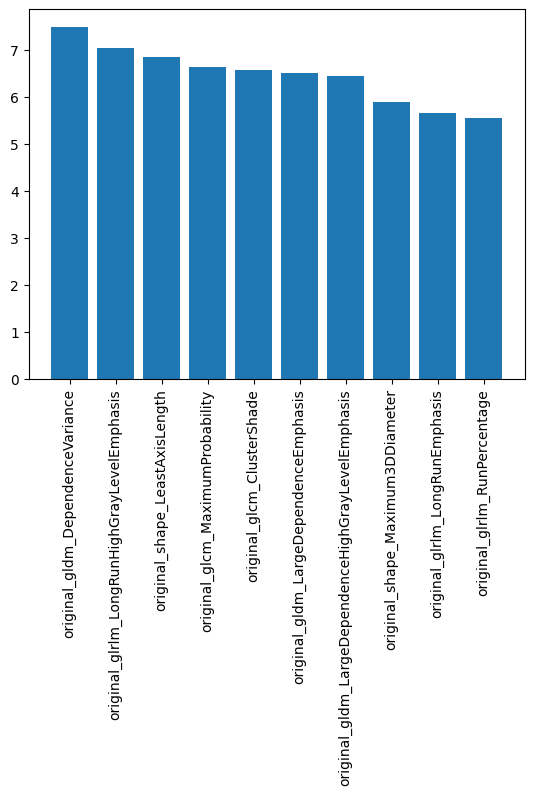

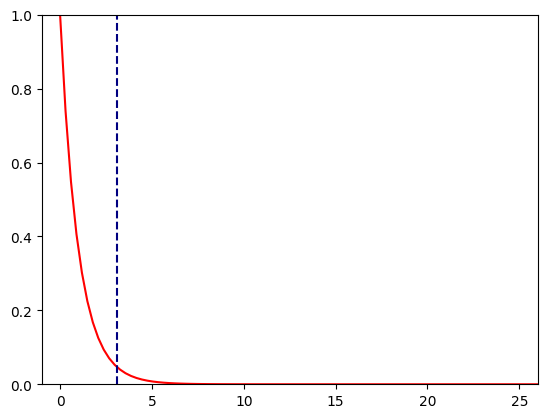

In [226]:
anova_selected_df,y = anova(data)
X_anova = anova_selected_df.values
stdsc = StandardScaler()
X_std_anova = stdsc.fit_transform(X_anova)
print(X_std_anova.shape)

In [227]:
RF_xy_testlist,RF_xy_trainlist = RF_CV(X_std_anova, y)

0 >acc=0.286, est=0.700, cfg={'criterion': 'entropy', 'min_samples_leaf': 5, 'n_estimators': 10}
1 >acc=0.857, est=0.623, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 10}
2 >acc=0.429, est=0.623, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 10}
3 >acc=0.571, est=0.685, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 10}
4 >acc=0.429, est=0.677, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 100}
5 >acc=0.571, est=0.638, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 100}
6 >acc=0.571, est=0.654, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 100}
7 >acc=0.571, est=0.669, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 10}
8 >acc=0.571, est=0.669, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 500}
9 >acc=0.571, est=0.677, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 100}
10 >acc=0.857, est=0.631, cfg={'criterion':

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/3828814591.py:13: DeprecationWarning:

scipy.interp is deprecated and w

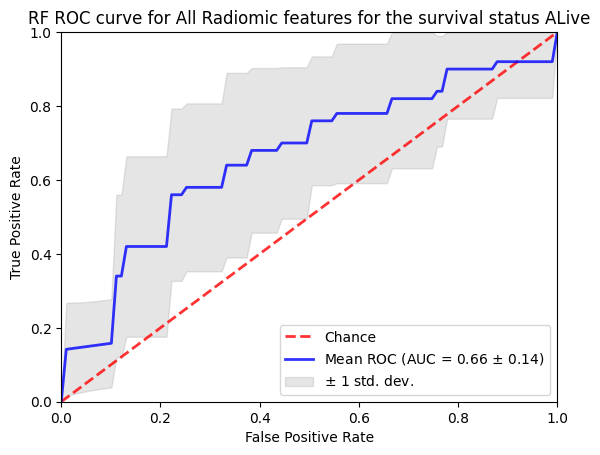

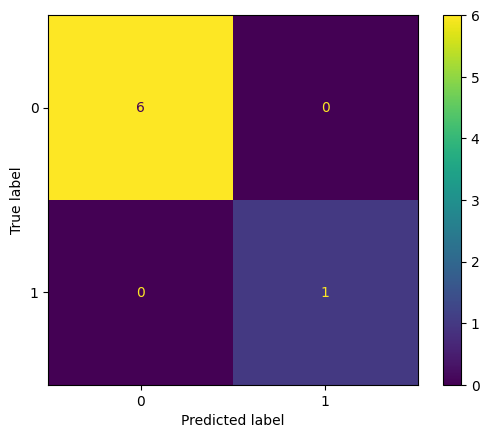

In [232]:
tprs,aucs,mean_fpr,forest = RandomForest_ROC(X_std_anova, y , criterion='gini',n_estimators=10,min_samples_leaf=5)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC curve for All Radiomic features for the survival status ALive')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(forest, RF_xy_testlist[12][0], RF_xy_testlist[12][1])

In [233]:
xy_testlist,xy_trainlist = SVM_CV(X_std_anova, y)

0 >acc=0.571, est=0.692, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
1 >acc=1.000, est=0.631, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
2 >acc=0.714, est=0.631, cfg={'C': 10, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
3 >acc=0.429, est=0.662, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
4 >acc=0.429, est=0.685, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
5 >acc=0.571, est=0.654, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
6 >acc=0.571, est=0.692, cfg={'C': 50, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
7 >acc=0.571, est=0.715, cfg={'C': 50, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
8 >acc=0.429, est=0.685, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
9 >acc=0.571, est=0.685, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
10 >acc=0.857, est=0.623, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
11 >ac

/tmp/ipykernel_4184355/1822684837.py:14: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/1822684837.py:14: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/1822684837.py:14: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/1822684837.py:14: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/1822684837.py:14: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/1822684837.py:14: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4184355/1822684837.py:14: DeprecationWarning:

scipy.interp is deprecated and w

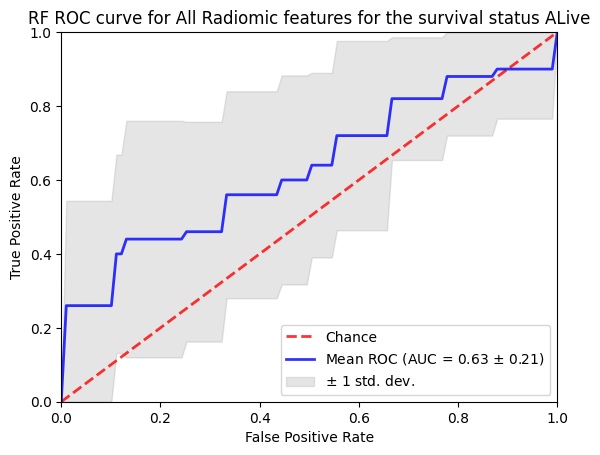

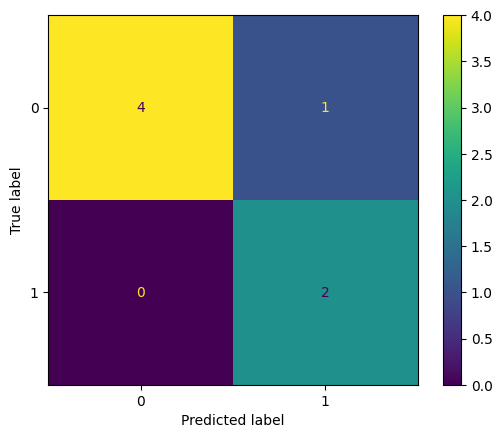

In [241]:
tprs,aucs,mean_fpr,svm = SVM_ROC(X_std_anova, y , C= 1, kernel = 'sigmoid' , decision_function_shape = 'ovo')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC curve for All Radiomic features for the survival status ALive')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(svm, xy_testlist[7][0], xy_testlist[7][1])